# Model to forecast inventory demand based on historical sales data. 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import time
import random
import pickle
import math

## Model accuracy is RMSLE

In [5]:
import warnings
warnings.filterwarnings("ignore")

def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

## Load Training Data 
The size of the training data is quite large (~4 GB). Large datasets require significant amount of memory to process. Instead, we will sample the data randomly for our initial data analysis and visualization. 

In [3]:
def load_samp_data(filename='train.csv', columns=[], load_pkl=1):
    """ 
      Function returns a dataframe containing the training data sampled randomly. 
      The data is also stored in a pickle file for later processing.
    """
    if load_pkl:
        inputfile = open('train_samp_data.pkl', 'rb')
        data = pickle.load(inputfile)
        inputfile.close()
        return data
    
    chunksize= 10 ** 6
    datasize = 74180464 #datasize = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
    samplesize = 2*10 ** 3 # samples per chunk of data read from the file.
    
    data = pd.DataFrame([],columns=columns)
    chunks = pd.read_csv(filename, iterator=True, chunksize=chunksize)
    for chunk in chunks:
        chunk.columns = columns
        data = data.append(chunk.sample(samplesize)) 
    
    # write data to a pickle file.
    outputfile = open('train_samp_data.pkl','wb')
    pickle.dump(data,outputfile)
    outputfile.close()
    
    return data
 
load_pkl = 1
columns = ['week_num', 'sales_depot_id', 'sales_chan_id', 'route_id', 'client_id', 'prod_id', 'saleunit_curr_wk', 'saleamt_curr_wk', 'retunit_next_week', 'retamt_next_wk', 'y_pred_demand']
tic = time.time()
train_data_samp = load_samp_data('train.csv', columns, load_pkl)
toc = time.time()
print '*********'
print 'Time to load: ', toc-tic, 'sec'
print 
print train_data_samp.describe()
print '*********'
print train_data_samp[['week_num', 'sales_depot_id', 'sales_chan_id', 'route_id', 'client_id', 'prod_id']]

*********
Time to load:  0.296472787857 sec

            week_num  sales_depot_id  sales_chan_id       route_id  \
count  150000.000000   150000.000000  150000.000000  150000.000000   
mean        5.982820     2785.281267       1.378807    2116.544753   
std         2.027124     4660.731926       1.454210    1486.426860   
min         3.000000     1110.000000       1.000000       1.000000   
25%         4.000000     1312.000000       1.000000    1162.000000   
50%         6.000000     1614.000000       1.000000    1287.000000   
75%         8.000000     2038.000000       1.000000    2803.000000   
max         9.000000    25759.000000      11.000000    9892.000000   

          client_id        prod_id  saleunit_curr_wk  saleamt_curr_wk  \
count  1.500000e+05  150000.000000     150000.000000    150000.000000   
mean   1.808100e+06   20917.492180          7.290980        68.851745   
std    1.839784e+06   18654.697725         21.046499       307.624295   
min    1.050000e+02      72.0000

## Preliminary analysis 
### 1. Linear Regression

In [4]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
features_train = train_data_samp[['week_num', 'sales_depot_id', 'sales_chan_id', 'route_id', 'client_id', 'prod_id']].values
labels_train = train_data_samp[['y_pred_demand']].values

# Split the data samples into train and test.
X_train, X_test, y_train, y_test = train_test_split(features_train, labels_train, test_size=0.33, random_state=42)

# Linear regression
tic = time.time()
clf = linear_model.LinearRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred[pred<0] = 0
tac = time.time()
print '----------'
print 'Time:', tac-tic, 'RMSLE (LinearRegression):', rmsle(pred, y_test)
print '----------'

----------
Time: 0.0148620605469 RMSLE (LinearRegression): 0.938368243688
----------


### 2. Random Forest Classifier

In [6]:
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from operator import itemgetter

clf = RandomForestClassifier(n_estimators=10)

# specify parameters and distributions to sample from
param_dist = {"max_depth": [10],
              "max_features": sp_randint(4, 7),
              }

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=4, cv=5)
start = time.time()
random_search.fit(features_train, np.ravel(labels_train))
predict = random_search.predict(features_train)
print '\nModel Report ********'
print "Accuracy : %.4g" % rmsle(np.ravel(labels_train), predict)
print '\nModel Report ********'
print
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.grid_scores_)
print random_search.best_score_ 
print random_search.best_estimator_ 


Model Report ********
Accuracy : 0.7968

Model Report ********

RandomizedSearchCV took 150.64 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.242 (std: 0.003)
Parameters: {'max_features': 5, 'max_depth': 10}

Model with rank: 2
Mean validation score: 0.241 (std: 0.003)
Parameters: {'max_features': 6, 'max_depth': 10}

Model with rank: 3
Mean validation score: 0.241 (std: 0.004)
Parameters: {'max_features': 6, 'max_depth': 10}

0.241613333333
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=5, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


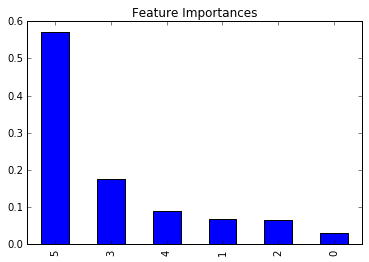

In [8]:
feat_imp = pd.Series(random_search.best_estimator_.feature_importances_).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

### 3. Gradient Boosting

In [9]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
from sklearn import metrics

In [12]:
def modelfit(alg, Xtrain, ytrain, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(Xtrain, label=ytrain)
        print alg.get_params()['n_estimators']
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = alg.get_params()['n_estimators'], early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        alg.fit(Xtrain, ytrain, eval_metric='auc')
        predict = alg.predict(Xtrain)
        return predict

## Step 1 Fix learning rate and number of estimators for tuning tree-based parameters

In [11]:
xgb1 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=100,
 max_depth=15,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 scale_pos_weight=1,
 seed=27)

predict = modelfit(xgb1, features_train, np.ravel(labels_train))

100


KeyboardInterrupt: 

In [ ]:
#print model report:
print '\nModel Report ********'
print "Accuracy : %.4g" % rmsle(np.ravel(labels_train), predict)
print '\nModel Report ********'
feat_imp = pd.Series(xgb1.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

## Step 2: Tune max_depth and min_child_weight

In [ ]:
from sklearn.grid_search import GridSearchCV
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1, seed=27),  param_grid = param_test1, scoring='roc_auc', n_jobs=4,iid=False)
gsearch1.fit(features_train,np.ravel(labels_train))
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

## Load Test Data

In [59]:
test_data = pd.read_csv('test.csv')
test_data.columns = ['id', 'week_num', 'sales_depot_id', 'sales_chan_id', 'route_id', 'client_id', 'prod_id']
test_labels = pd.read_csv('sample_submission.csv')
test_data = test_data.drop('id', 1)
print test_data.head()

   week_num  sales_depot_id  sales_chan_id  route_id  client_id  prod_id
0        11            4037              1      2209    4639078    35305
1        11            2237              1      1226    4705135     1238
2        10            2045              1      2831    4549769    32940
3        11            1227              1      4448    4717855    43066
4        11            1219              1      1130     966351     1277


## Submission

In [ ]:
Xtest = test_data[['week_num', 'sales_depot_id', 'sales_chan_id', 'route_id', 'client_id', 'prod_id']].values
y_pred = []
tic = time.time()
for ipred in xrange(len(Xtest)):
    if ipred%10e4 == 0:
        print ipred, ' ', time.time()-tic
    y_pred.append(max(0, random_search.predict(Xtest[ipred,:])[0]))
sub_dict = {'Demanda_uni_equil': np.ravel(y_pred)}
sub_df = pd.DataFrame(sub_dict)
sub_df.to_csv('sample_submission.csv', sep='\t')

0   0.000306844711304
100000   72.7710800171
200000   145.477372885
300000   218.045004845
400000   290.581101894
500000   363.356217861
600000   436.15059185
700000   509.013458014
800000   581.852082014
900000   654.530701876
1000000   727.205648899
1100000   800.080030918
1200000   872.742459059
1300000   945.787395
1400000   1018.40329695
1500000   1090.79495907
1600000   1163.17800498
1700000   1235.77449584
1800000   1308.24206305
